## Sentiment Analysis on  [Sentiment140](http://help.sentiment140.com/for-students). 
Sentiment140 is an automatically retrieved and sentiment tagged dataset from Twitter. The dataset was created by [Go et al.](https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf) and uses emoticons to automatically classify the sentiment in a tweet and therefore provides a resource of 1.600.000 polarity annotated tweets. In the following we implemented a neural network trained on a subset of these tweets aiming to correctly identify its polarity. For this task we used  the [ELMo](https://github.com/HIT-SCIR/ELMoForManyLangs) word embedding vectors to represent our tweets numerically in a semantic concept space. 

**Imports**

In [2]:
import os
import random

import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
import numpy as np
import matplotlib.pyplot as plt
import csv
import re
import nltk
from elmoformanylangs import Embedder

c:\users\tobias.nusser\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\tobias.nusser\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\tobias.nusser\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 

**Functions**

In [3]:
def read_in(path_to_file):
    """
    Reads in training and test data and removes all neutral tweets
    from test data because the training data lacks neutral tagged tweets.
    Due to hardware restrictions we used only < 1/100th of the available 
    training dataset (14.000 tweets)
    """
    out = []
    with open(path_to_file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            if not row[0] == "2":
                out.append([row[0], row[5]])
        random.shuffle(out)
    return out[:150000]


def preprocess(data):
    """
    Preprocesses and tokenizes data
    """
    label = []
    tweet = []
    print("Preprocessing...")
    for row in data:
        cleaned = clean_regex(row[1].lower())
        if cleaned.__len__() > 1:
            if row[0] == "0":
                label.append(0)
            else:
                label.append(1)
            tokenized = nltk.word_tokenize(cleaned)
            # pos_tagged = nltk.pos_tag(tokenized)
            tweet.append(tokenized)
    print("Done")
    return tweet, label


def clean_regex(tweet):
    """
    Regex that removes links to other users, and all hyperlink mentions
    """
    cleaned = re.sub('@.*?(?:\s|$)', '', tweet)
    cleaned2 = re.sub('http.*?(?:\s|$)', '', cleaned)
    cleaned3 = re.sub('www.*?(?:\s|$)', '', cleaned2)
    return cleaned3

def parse_to_dict(file_path):
    """
    Creates hashmap with word as key and concept vector as value
    :param file_path: path to the conceptnet dictionary file
    :return: hashmap of word and vectors
    """
    concept_hash = {}
    with open(file_path, encoding="utf8") as f:
        text = f.readlines()[1:]
        for line in text:
            first_item = line.split(" ").__getitem__(0)
            concept_hash[first_item] = line
    f.close()
    return concept_hash

def find_word(word, concept_hash):
    """
    Finds conceptnet vector for a word in the conceptnet hashmap
    :param word: input word to analyze
    :param concept_hash: hashmap of word and conceptnet vector
    :return: returns the appropriate vector or none if its not in the hashmap
    """
    if word in concept_hash.keys():
        vector = concept_hash[word].split(" ")[1:]
        vector = [float(i) for i in vector]
    else:
        vector = None
    return vector
  
def fill_list(data):
    """
    Fills or cuts list of tokens for a tweet at 35, to ensure consistent vector dimensions
    """
    res = []
    for row in data:
        copy = row
        if len(row) < 35:
            copy += [''] * (35 - len(row))
        elif len(row) > 35:
            copy = row[:35]   
        res.append(copy)
    return res




**Preprocessing**

In [4]:
print(os.getcwd())
#base_path = "C:/Users/Tobias.Nusser/PycharmProjects/sentiment_learning"
base_path = os.getcwd()
training_data, training_label = preprocess(read_in(base_path + "/data/training.csv"))
test_data, test_label = preprocess(read_in(base_path + "/data/test.csv"))

C:\Users\Tobias.Nusser\AppData\Local\Programs\Python\Python37\Scripts
Preprocessing...
Done
Preprocessing...
Done


**Split into training and validation set**

In [11]:
train_data = fill_list(training_data[:12000])
train_label = np.asarray(training_label[:12000])
val_data = fill_list(training_data[12000:14000])
val_label = np.asarray(training_label[12000:14000])

**Load ELMO word embeddings in RAM**

In [9]:
# Load word embedding vectors into RAM
e = Embedder(base_path + '/embeddings/elmo/144/', batch_size=48)

**Retrieve word embedding vectors for training and validation data**

In [12]:
train_embedding_matrix = np.asarray(e.sents2elmo(train_data))
val_embedding_matrix = np.asarray(e.sents2elmo(val_data))

**Neural Network Model**

Sequential model with three Dense Layers and one Flatten layer to flatten 3D input matrix.
*Relu* as activation function and simple *sigmoid* function for the output layer. Because of the binary classification task we used a simple *accuracy* metric and *binary crossentropy* as loss function. As optimizer we used *rmsprop*, which performed best according to some tests.

In [13]:
model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(35,1024,)))
model.add(layers.Flatten())
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
print(model.summary())
history = model.fit(train_embedding_matrix,
                    train_label,
                    epochs=19,
                    batch_size=256,
                    validation_data=(val_embedding_matrix, val_label), verbose=1)

W0805 15:45:14.989325  7380 deprecation_wrapper.py:119] From c:\users\tobias.nusser\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 15:45:15.023327  7380 deprecation_wrapper.py:119] From c:\users\tobias.nusser\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 15:45:15.033328  7380 deprecation_wrapper.py:119] From c:\users\tobias.nusser\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0805 15:45:15.117332  7380 deprecation_wrapper.py:119] From c:\users\tobias.nusser\appdata\local\programs\python\python37\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimiz

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 35, 20)            20500     
_________________________________________________________________
flatten_1 (Flatten)          (None, 700)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                14020     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 34,541
Trainable params: 34,541
Non-trainable params: 0
_________________________________________________________________
None


W0805 15:45:15.434351  7380 deprecation_wrapper.py:119] From c:\users\tobias.nusser\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 12000 samples, validate on 2000 samples
Epoch 1/19
12000/12000 [==============================] - ETA: 15s - loss: 0.7021 - acc: 0.46 - ETA: 8s - loss: 0.8249 - acc: 0.4551 - ETA: 6s - loss: 0.7796 - acc: 0.485 - ETA: 5s - loss: 0.7579 - acc: 0.485 - ETA: 4s - loss: 0.7441 - acc: 0.502 - ETA: 4s - loss: 0.7342 - acc: 0.517 - ETA: 3s - loss: 0.7287 - acc: 0.516 - ETA: 3s - loss: 0.7232 - acc: 0.525 - ETA: 3s - loss: 0.7185 - acc: 0.534 - ETA: 3s - loss: 0.7147 - acc: 0.539 - ETA: 2s - loss: 0.7114 - acc: 0.545 - ETA: 2s - loss: 0.7077 - acc: 0.552 - ETA: 2s - loss: 0.7053 - acc: 0.553 - ETA: 2s - loss: 0.7056 - acc: 0.549 - ETA: 2s - loss: 0.7044 - acc: 0.546 - ETA: 2s - loss: 0.7027 - acc: 0.547 - ETA: 2s - loss: 0.7014 - acc: 0.548 - ETA: 2s - loss: 0.6998 - acc: 0.551 - ETA: 1s - loss: 0.6979 - acc: 0.556 - ETA: 1s - loss: 0.6962 - acc: 0.558 - ETA: 1s - loss: 0.6946 - acc: 0.560 - ETA: 1s - loss: 0.6925 - acc: 0.565 - ETA: 1s - loss: 0.6910 - acc: 0.566 - ETA: 1s - loss: 0.

**Plotting accuracy and loss in the training phase**

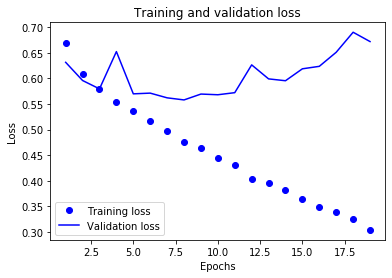

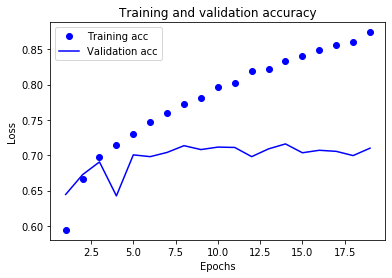

In [14]:
# Loss plot
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy plot
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Evaluating model on test data**

In [24]:
print("Evaluate")
test_label = np.asarray(test_label)
test_embedding_matrix = np.asarray(e.sents2elmo(fill_list(test_data)))
results = model.evaluate(test_embedding_matrix, test_label)
print("Loss: ", results[0])
print("Accuracy: ", results[1])

Evaluate
359/359 [==============================] - ETA:  - ETA:  - 0s 281us/step
Loss:  0.7127544417520751
Accuracy:  0.6824512538139534


**Results**

We trained our network on 14.000 samples (12.000 training and 2000 validation samples) and used the word embedding vectors obtained by ELMo. Due to ELMo's large number of embedding dimensions (1024) and our limited hardware, we only trained on a 100th of the available training data. We achieved accuracies in-between 68%-72%, which is relatively disappointing compared to the lower-dimensional ConceptNet word embeddings. It would be interesting to train the network on more samples however. 